<a href="https://colab.research.google.com/github/exactful/generative-adversarial-networks/blob/main/mnist_digits_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Generative Adversarial Network for handwritten digits**

Generating images of handwritten digits using a Keras GAN and the MNIST digits dataset

In [1]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time

from tensorflow.keras import layers
from IPython import display

In [2]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [3]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype("float32")
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [4]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [5]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [6]:
# Generator model
# Uses tf.keras.layers.Conv2DTranspose (upsampling) layers to produce an image from a seed (random noise)
# Start with a Dense layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1
# Notice the tf.keras.layers.LeakyReLU activation for each layer, except the output layer which uses tanh

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding="same", use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding="same", use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding="same", use_bias=False, activation="tanh"))
    assert model.output_shape == (None, 28, 28, 1)

    return model

# Discriminator model
# This is a CNN-based image classifier

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same",
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [7]:
generator = make_generator_model()
discriminator = make_discriminator_model()

In [8]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [9]:
# Quantifies how well the discriminator is able to distinguish real images from fakes
# Compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    
    return total_loss

# Quantifies how well the generator was able to trick the discriminator
# Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1)
# Here, compare the discriminators decisions on the generated images to an array of 1s

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [10]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [11]:
EPOCHS = 75
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [12]:
# Training loop begins with generator receiving a random seed as input; that seed is used to produce an image
# The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator)
# The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator

# Notice the use of tf.function
# This annotation causes the function to be "compiled"
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)
      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

      # print(f"Gen loss: {float(gen_loss)} Disc loss: {float(disc_loss)}") # Remove @tf.function first

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [13]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch + 1, seed)

    print ("Time for epoch {} is {} sec".format(epoch + 1, time.time()-start))

In [14]:
def generate_and_save_images(model, epoch, test_input):
  # Notice training is set to False
  # This is so all layers run in inference mode (batchnorm)
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap="gray")
      plt.axis("off")

  plt.savefig("image_at_epoch_{:04d}.png".format(epoch))
  plt.show()

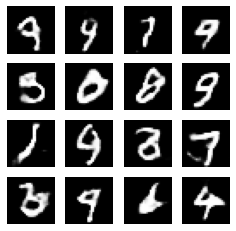

Time for epoch 75 is 24.893614530563354 sec


In [15]:
train(train_dataset, EPOCHS)